In [5]:
!pip install langchain langchain-openai
!pip install langgraph

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [7]:

from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI

In [8]:
import os
import getpass

if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key:  ········


In [9]:
from langchain_core.prompts import PromptTemplate

In [12]:
from langchain_openai import ChatOpenAI
# Initialize the ChatOpenAI model
llm = ChatOpenAI(
    model_name="gpt-4o",  # Specify the model (e.g., gpt-4, gpt-3.5-turbo)
    temperature=0.7,      # Controls randomness (0 to 1)
    max_tokens=512        # Maximum tokens in the response
)

In [15]:
# State
class State(TypedDict):
	input: str
	decision: str
	output: str

In [20]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display


# Schema for strctured output to use as routing logic
class Route(BaseModel):
	step: Literal["Finance", "Portfolio ", "Goal", "News", "Tax"] = Field(
		None, description="The next step in the routing prcess"
	)

# Agument the LLM with schema for structured output

router = llm.with_structured_output(Route)

In [21]:
from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.messages import SystemMessage, HumanMessage
# Nodes
def call_llm_1(state: State):
	""" Finance Q&A Agent """

	print(" Finance Q&A Agent: Handles general financial education queries ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_llm_2(state: State):
	""" Portfolio Analysis Agent """

	print(" Reviews and analyzes user portfolios ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_llm_3(state: State):
	""" Market Analysis Agent"""

	print(" Provides real-time market insights ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_llm_4(state: State):
	""" Goal Planning Agent"""

	print(" Assists with financial goal setting and planning ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_llm_5(state: State):
	""" News Synthesizer Agent"""

	print(" Summarizes and contextualizes financial news ")
	result = llm.invoke(state["input"])
	return {"output": result.content}

def call_llm_6(state: State):
	""" Tax Education Agent"""

	print(" Explains tax concepts and account types ")
	result = llm.invoke(state["input"])
	return {"output": result.content}


def call_llm_router(state: State):
  """Route the input to the appropriate node """

  # Run the agumented LLM with strctured output to serve as routing logic
  decision = router.invoke(
		[
			SystemMessage(
				content="Route the input to finance, portfolio, goal, news or tax based on user request"
			),
			HumanMessage(content=state["input"]),

		]
	)
  return {"decision": decision.step}


# Conditional edge function to route the appropriate node
def route_decision(state: State):
	# Return the node name you want to visit next
	if state["decision"] == "finance":
		return "call_llm_1"
	elif state["decision"] == "portfolio":
		return "call_llm_2"
	elif state["decision"] == "market":
		return "call_llm_3"
	elif state["decision"] == "goal":
		return "call_llm_4"
	elif state["decision"] == "news":
		return "call_llm_5"
	elif state["decision"] == "tax":
		return "call_llm_6"
	else:
		return "call_llm_1"

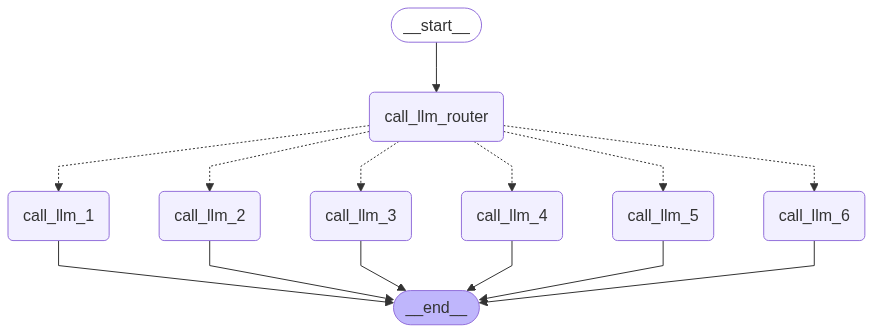

In [23]:
# Build workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("call_llm_1", call_llm_1)
router_builder.add_node("call_llm_2", call_llm_2)
router_builder.add_node("call_llm_3", call_llm_3)
router_builder.add_node("call_llm_4", call_llm_4)
router_builder.add_node("call_llm_5", call_llm_5)
router_builder.add_node("call_llm_6", call_llm_6)

router_builder.add_node("call_llm_router", call_llm_router)

# Add edges to connect nodes
router_builder.add_edge(START, "call_llm_router")
router_builder.add_conditional_edges(
    "call_llm_router",
    route_decision,
    {  # Name returned by route_decision : Name of next node to visit
        "call_llm_1": "call_llm_1",
        "call_llm_2": "call_llm_2",
        "call_llm_3": "call_llm_3",
        "call_llm_4": "call_llm_4",
        "call_llm_5": "call_llm_5",
        "call_llm_6": "call_llm_6",
    },
)

router_builder.add_edge("call_llm_1", END)
router_builder.add_edge("call_llm_2", END)
router_builder.add_edge("call_llm_3", END)
router_builder.add_edge("call_llm_4", END)
router_builder.add_edge("call_llm_5", END)
router_builder.add_edge("call_llm_6", END)

# compile workflow
router_workflow = router_builder.compile()

# Show the workflow
display(Image(router_workflow.get_graph().draw_mermaid_png()))